## YouTube Trending Video Analysis & Prediction

### Joel Day, Caleb McCurdy, & Lane Whitmore

### The University of San Diego

#### ADS 508 - Data Science Cloud Computing

In [3]:
# General imports
import pandas as pd
import numpy as np

# nlp processing imports
import string
import re
import nltk

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# Sagemaker imports
import sagemaker
# from sagemaker.sklearn.processing import 
from sagemaker import get_execution_role
from sklearn.feature_extraction.text import CountVectorizer

# athena connection imports
!pip install pyathena
from pyathena import connect
import boto3

  Using cached pyathena-2.23.0-py3-none-any.whl (67 kB)


## Establishing Athena for SQL Queries

In [4]:
region = boto3.Session().region_name
role = get_execution_role()

In [5]:
# Set Athena for data wrangling // exploration
session = sagemaker.Session()

# this sets the bucket to the default sagemaker bucket
bucket = session.default_bucket()

In [6]:
ingest_create_athena_db_passed = False

db_name = "youtubedb"

In [7]:
# temp query storage
s3_athena = "s3://{}/athena/tmp/".format(bucket)

# file storage
youtube_dir = "s3://{}/athena/files/".format(bucket)

# creating connection to database
conn = connect(region_name=region, s3_staging_dir=s3_athena)

### Creating Database

In [8]:
# Creating DATABASE with db_name above
create_db = "CREATE DATABASE IF NOT EXISTS {}".format(db_name)

pd.read_sql(create_db, conn)

""


### Creating Tables

#### CSV Tables

Currently, the tables below are still struggling to appropriately populate the tables. If the data type is anything but strings, the column becomes null for all values and the comma seperation is not consistent.

In [9]:
pd.read_sql(f"DROP TABLE IF EXISTS {db_name}.ca_csv", conn)


ca_csv_create = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {db_name}.ca_csv(
                video_id string,
                title string,
                publishedAt string,
                channelId string,
                channelTitle string,
                categoryId string,
                trending string,
                tags string,
                view_count string,
                likes string,
                dislikes string,
                comment_count string,
                thumbnail_link string,
                comments_disabled string,
                ratings_disabled string,
                description string)
            
                
                ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde' 
                WITH SERDEPROPERTIES (
                "separatorChar" = ",", 
                "quoteChar" = '\"',
                "escapeChar" = '\"'
                ) 
                LOCATION 's3://ads508youtubebucket/youtubeStatistics/csv/can/'
                TBLPROPERTIES ("skip.header.line.count"="1");
"""

pd.read_sql(ca_csv_create, conn)

""


In [10]:
pd.read_sql(f"SELECT * FROM {db_name}.ca_csv LIMIT 10", conn)

,video_id,title,publishedat,channelid,channeltitle,categoryid,trending,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,W4SNGzEdRXU,TikToks To Never Show Your Doctor,2022-10-02T14:00:23Z,UC0QHWhjbe5fGJEPz3sVb6nw,Doctor Mike,27,2022-10-06T00:00:00Z,doctor mike|dr mike|drmike|dr. mike|mikhail va...,2149706,82838,0,3631,https://i.ytimg.com/vi/W4SNGzEdRXU/default.jpg,False,False,Keep exploring at https://brilliant.org/Doctor...
1,16Ci_2bN_zc,The Fatal Physics of Falling Objects,2022-10-01T15:00:11Z,UCHnyfMqiRRG1u-2MsSQLbXA,Veritasium,27,2022-10-06T00:00:00Z,veritasium|science|physics,3044706,130903,0,6030,https://i.ytimg.com/vi/16Ci_2bN_zc/default.jpg,False,False,This video is sponsored by Brilliant. You can ...
2,1NlT4LZGCZc,"I Promised Myself I'd NEVER Buy This Terrible,...",2022-10-02T20:02:57Z,UCvAhDxNNUDhi78tMXVGBUaQ,Tavarish,2,2022-10-06T00:00:00Z,aston martin|mercedes|amg|hyundai|bmw|lamborgh...,592883,26181,0,1597,https://i.ytimg.com/vi/1NlT4LZGCZc/default.jpg,False,False,Thanks to Keeps for sponsoring - Head to https...
3,biQRFzsHv9U,2 mois pour devenir pilote ! (GP Explorer),2022-10-02T09:00:17Z,UCGWoTWsXJi1UtCjOiBHIsfw,Sofyan,24,2022-10-06T00:00:00Z,sofyan|film|squeezie|formule 4|seb|seb la frit...,563832,57460,0,1782,https://i.ytimg.com/vi/biQRFzsHv9U/default.jpg,False,False,Mon aventure de 60 jours pour être pilote avan...
4,r4LZ-eepkGM,Season 1 Episode 8 Preview | House of the Drag...,2022-10-03T02:00:24Z,UCQzdMyuz0Lf4zo4uGcEujFw,GameofThrones,22,2022-10-06T00:00:00Z,[None],2946792,46666,0,5305,https://i.ytimg.com/vi/r4LZ-eepkGM/default.jpg,False,False,New episodes premiere Sundays at 9 pm ET on HB...
5,vK6D4bp48IU,whats going on with Eryn.....,2022-10-02T19:26:17Z,UCKMugoa0uHpjUuq14yOpagw,Laura Lee,26,2022-10-06T00:00:00Z,LauraLee|get ready with me|grwm|get ready with...,331326,12227,0,1074,https://i.ytimg.com/vi/vK6D4bp48IU/default.jpg,False,False,Shop my BoutiqueShop My Clothing Brand: https:...
6,eLDCS3ScSr4,ratios are a nightmare,2022-10-02T16:08:14Z,UCj74rJ9Lgl3WTngq675wxKg,Noodle,1,2022-10-06T00:00:00Z,[None],543243,57390,0,3213,https://i.ytimg.com/vi/eLDCS3ScSr4/default.jpg,False,False,Get 20% off + FREE International Shipping with...
7,sq0esaLMZqY,Je deviens la PIRE prof dans une école (les pa...,2022-10-02T09:24:36Z,UClOeGHFiUlegRJFGhkMxoHg,DENYZEE,23,2022-10-06T00:00:00Z,denyzee|denize|denyze|denizee|humour|vidéo drô...,256455,12362,0,422,https://i.ytimg.com/vi/sq0esaLMZqY/default.jpg,False,False,Je deviens professeur dans une école sans avoi...
8,RB-aBItqdbo,HIGHLIGHTS | Arsenal vs Tottenham Hotspur (3-1...,2022-10-01T21:00:17Z,UCpryVRk_VDudG8SHXgWcG0w,Arsenal,17,2022-10-06T00:00:00Z,Arsenal|Arsenal FC|Arsenal Football Club|Footb...,2752286,50698,0,1597,https://i.ytimg.com/vi/RB-aBItqdbo/default.jpg,False,False,"Goals from Thomas Partey, Gabriel Jesus and Gr..."
9,iGf4-XBGLOs,We’re DOOMED: Young Americans know nothing!,2022-10-02T20:30:28Z,UCyoEZ7icpGsUlki08Is8v9g,loveliveserve,24,2022-10-06T00:00:00Z,Loveliveserve|lls|love live serve|Noah boat|rh...,272321,20295,0,1047,https://i.ytimg.com/vi/iGf4-XBGLOs/default.jpg,False,False,Shop below!https://www.strawberrypark.storeSub...


In [11]:
pd.read_sql(f"DROP TABLE IF EXISTS {db_name}.us_csv", conn)


us_csv_create = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {db_name}.us_csv(
                video_id string,
                title string,
                publishedAt string,
                channelId string,
                channelTitle string,
                categoryId string,
                trending string,
                tags string,
                view_count string,
                likes string,
                dislikes string,
                comment_count string,
                thumbnail_link string,
                comments_disabled string,
                ratings_disabled string,
                description string)
            
                
                ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde' 
                WITH SERDEPROPERTIES (
                "separatorChar" = ',', 
                "quoteChar" = '\"',
                "escapeChar" = '\"'
                ) 
                LOCATION 's3://ads508youtubebucket/youtubeStatistics/csv/usa/'
                TBLPROPERTIES ("skip.header.line.count"="1");
"""

pd.read_sql(us_csv_create, conn)

""


In [12]:
pd.read_sql(f"SELECT * FROM {db_name}.us_csv LIMIT 10", conn)

,video_id,title,publishedat,channelid,channeltitle,categoryid,trending,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,uW1ixpmEwiQ,The Eternals Out Of Theater Reaction,2021-10-19T07:10:16Z,UCYyDbdaja1UDNdFSwUrYVGA,John Campea,24,2021-10-20T00:00:00Z,John Campea|tobeornottobethatisthequestion|Ete...,140965,6550,217,766,https://i.ytimg.com/vi/uW1ixpmEwiQ/default.jpg,False,False,John gives his first reaction to Marvel's The ...
1,QiJDc7EOkR4,Ben Simmons reportedly appeared disengaged at ...,2021-10-19T17:00:36Z,UCLXzq85ijg2LwJWFrz4pkmw,Skip and Shannon: UNDISPUTED,17,2021-10-20T00:00:00Z,fox|fox sports|fs1|fox sports 1|undisputed|ski...,489010,7238,215,1229,https://i.ytimg.com/vi/QiJDc7EOkR4/default.jpg,False,False,Ben Simmons seemed disengaged in his return to...
2,sqgxcCjD04s,[MV] IU(아이유) _ strawberry moon,2021-10-18T15:00:28Z,UCweOkPb1wVVH0Q0Tlj4a5Pw,1theK (원더케이),24,2021-10-20T00:00:00Z,K-POP|Kpop|1theK|원더케이|Original|1theK Original|...,6723827,709082,5744,36010,https://i.ytimg.com/vi/sqgxcCjD04s/default.jpg,False,False,[MV] IU(아이유) _ strawberry moonK-POP Wonderland...
3,bdZoNOqv4-o,Which of My Eleven Husky Puppies Am I Keeping?!,2021-10-18T21:15:03Z,UCGCPAOQDZa_TTTXDr5byjww,Joey Graceffa,15,2021-10-20T00:00:00Z,joey|graceffa|pregnant husky|pregnant dog|preg...,245363,20743,95,1987,https://i.ytimg.com/vi/bdZoNOqv4-o/default.jpg,False,False,None
4,ORDER REBELS OF EDEN: https://www.joeygraceffa...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
5,SUBSCRIBE: http://bit.ly/JoeyGraceffaSubscribe,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
6,FOLLOW ME ON TWITTER: https://twitter.com/joey...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
7,FOLLOW ME ON INSTAGRAM: https://www.instagram....,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
8,GAMING CHANNEL: http://bit.ly/JoeyGraceffaGame...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
9,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [13]:
pd.read_sql(f"DROP TABLE IF EXISTS {db_name}.gb_csv", conn)


gb_csv_create = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {db_name}.gb_csv(
                video_id string,
                title string,
                publishedAt string,
                channelId string,
                channelTitle string,
                categoryId string,
                trending string,
                tags string,
                view_count string,
                likes string,
                dislikes string,
                comment_count string,
                thumbnail_link string,
                comments_disabled string,
                ratings_disabled string,
                description string
                )
            
                ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde' 
                WITH SERDEPROPERTIES (
                "separatorChar" = ",", 
                "quoteChar" = '\"',
                "escapeChar" = '\"'
                ) 
                LOCATION 's3://ads508youtubebucket/youtubeStatistics/csv/gb/'
                TBLPROPERTIES ("skip.header.line.count"="1");
"""

pd.read_sql(gb_csv_create, conn)

""


In [14]:
pd.read_sql(f"SELECT * FROM {db_name}.gb_csv LIMIT 10", conn)

,video_id,title,publishedat,channelid,channeltitle,categoryid,trending,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,lMBXncqJYV0,Euro 2020: Italian team returns home after tou...,2021-07-12T05:44:28Z,UC86dbj-lbDks_hZ5gRKL49Q,AFP News Agency,25,2021-07-14T00:00:00Z,1ST|IMAGES|FBL|EURO|2020|2021|AFP|NEWS|ACTU|INFO,1103798,18370,405,1929,https://i.ytimg.com/vi/lMBXncqJYV0/default.jpg,False,False,"The Italian Euro 2020 team arrives in Rome, st..."
1,SBIKp51Qhs0,Finally Asking Nailea about Vinnie Hacker | Di...,2021-07-11T17:00:10Z,UCLOEGprmycLLbyzBj2jozLg,Dixie D'Amelio,22,2021-07-14T00:00:00Z,Dixie D'Amelio|The Early Late Night Show|Naile...,932015,58047,1307,2432,https://i.ytimg.com/vi/SBIKp51Qhs0/default.jpg,False,False,Hi everyone! Welcome back to another episode o...
2,f9mdVVXPHgQ,US vs UK Jollibee | Food Wars,2021-07-11T16:00:26Z,UCwiTOchWeKjrJZw7S1H__1g,Food Insider,19,2021-07-14T00:00:00Z,INSIDER|FOOD INSIDER|Food Wars|Jolibee|Fried C...,419735,13313,137,1679,https://i.ytimg.com/vi/f9mdVVXPHgQ/default.jpg,False,False,"From calorie count to portion sizes, we ordere..."
3,kic4V8eP_iQ,"Mini Trip to London, Haul & Getting Outside",2021-07-10T18:52:11Z,UCrUbqTCagwsaP2Fmr0p1TsA,Zoe Sugg,22,2021-07-14T00:00:00Z,Zoe Sugg|vlog|Zoella|makeup|grwm|get ready wit...,548423,22944,224,320,https://i.ytimg.com/vi/kic4V8eP_iQ/default.jpg,False,False,"Mini Trip to London, Haul & Getting OutsideLin..."
4,lGI_zSBJKfg,"CHUNKZ, FILLY AND JACK EAT BAMBINO BECKYS JERK...",2021-07-10T18:00:10Z,UCSTJELgD0j0gW2_wgF_TYuA,Footasylum,24,2021-07-14T00:00:00Z,chunkz|nella rose|footasylum|does the shoe fit...,611808,25177,126,670,https://i.ytimg.com/vi/lGI_zSBJKfg/default.jpg,False,False,https://www.footasylum.com/ Subscribe if you’r...
5,ZX5dR63n7jo,FIRST FIFA 22 REVEAL! | CREATE A CLUB CAREER M...,2021-07-11T18:15:27Z,UC5Qb_4X2CkAnvacIj94Xxzw,MGH,20,2021-07-14T00:00:00Z,FIFA|Gameplay|Career Mode|Ultimate Team|Pro Cl...,74307,2983,80,454,https://i.ytimg.com/vi/ZX5dR63n7jo/default.jpg,False,False,WATCH ME LIVE! http://www.fb.gg/mghfbJoin my D...
6,jSIdllridsg,Richard Branson reaches edge of space on Virgi...,2021-07-11T17:11:08Z,UCrp_UI8XtuYfpiqluWLD7Lw,CNBC Television,25,2021-07-14T00:00:00Z,Bottom Line|CNBC|business news|finance stock|s...,355801,3478,296,1119,https://i.ytimg.com/vi/jSIdllridsg/default.jpg,False,False,"Sir Richard Branson, after nearly 17 years of ..."
7,SAwlqiXD2aw,Disappointed fans leave Wembley following Euros,2021-07-12T02:21:17Z,UCnQvCx33v1mrgleEwVH4DxA,MrBeanyman,17,2021-07-14T00:00:00Z,Football|Soccer|Beanyman|BeanymanSports|Beany|...,104357,891,32,788,https://i.ytimg.com/vi/SAwlqiXD2aw/default.jpg,False,False,Tens of thousands of dejected England fans hav...
8,oFqVvjq6BGM,Dave - Clash (ft. Stormzy),2021-07-09T11:20:45Z,UC5-cg5RahETrjGu-r8zjYCQ,Santan Dave,10,2021-07-14T00:00:00Z,[None],3317477,148824,2616,8503,https://i.ytimg.com/vi/oFqVvjq6BGM/default.jpg,False,False,Stream Clash: https://santandave.lnk.to/ClashF...
9,XeuXShFIgyc,Why Millions Buy Harley-Davidson Motorcycles,2021-07-11T15:00:13Z,UCNSMdQtn1SuFzCZjfK2C7dQ,FortNine,2,2021-07-14T00:00:00Z,[None],542191,37219,462,4254,https://i.ytimg.com/vi/XeuXShFIgyc/default.jpg,False,False,None


#### JSON Tables

In [15]:

pd.read_sql(f"DROP TABLE IF EXISTS {db_name}.ca_json", conn)

ca_json_create = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {db_name}.ca_json (
                        kind string, 
                        etag string, 
                        items array<struct<kind: string, 
                                            etag: string,
                                            id: string,
                                            snippet: array<struct<
                                                            title: string,
                                                            assignable: string,
                                                            channelId: string
                                                    >>
                                        >>
                        )
                        ROW FORMAT SERDE 'org.openx.data.jsonserde.JsonSerDe'
                        WITH SERDEPROPERTIES ( 
                                                "ignore.malformed.json"="true"
                                             )
                        LOCATION 's3://ads508youtubebucket/youtubeStatistics/json/can/';
"""

pd.read_sql(ca_json_create, conn)

""


In [16]:
query_json_ca = f"""SELECT 
                    its.kind, 
                    its.etag, 
                    its.id, 
                    snt.title, 
                    snt.assignable, 
                    snt.channelId 
                    FROM {db_name}.ca_json, 
                    UNNEST(ca_json.items) AS t(its),
                    UNNEST(its.snippet) AS t(snt)
                    WHERE snt.title = 'gaming';
"""

pd.read_sql(query_json_ca, conn)

,kind,etag,id,title,assignable,channelId


In [17]:
pd.read_sql(f"DROP TABLE IF EXISTS {db_name}.gb_json", conn)

gb_json_create = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {db_name}.gb_json (
                        kind string, 
                        etag string, 
                        items array<struct<kind: string, 
                                            etag: string,
                                            id: string,
                                            snippet: array<struct<
                                                            title: string,
                                                            assignable: string,
                                                            channelId: string
                                                    >>
                                        >>
                        )
                        ROW FORMAT SERDE 'org.openx.data.jsonserde.JsonSerDe'
                        WITH SERDEPROPERTIES ( 
                                                "ignore.malformed.json"="true"
                                             )
                        LOCATION 's3://ads508youtubebucket/youtubeStatistics/json/gb/';
"""

pd.read_sql(gb_json_create, conn)

""


In [18]:
query_json_gb = f"""SELECT 
                    its.kind, 
                    its.etag, 
                    its.id, 
                    snt.title, 
                    snt.assignable, 
                    snt.channelId 
                    FROM {db_name}.gb_json, 
                    UNNEST(gb_json.items) AS t(its),
                    UNNEST(its.snippet) AS t(snt)
                    WHERE snt.title = 'gaming';
"""

pd.read_sql(query_json_gb, conn)

,kind,etag,id,title,assignable,channelId


In [19]:
pd.read_sql(f"DROP TABLE IF EXISTS {db_name}.us_json", conn)

us_json_create = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {db_name}.us_json (
                        kind string, 
                        etag string, 
                        items ARRAY< struct< kind: string, 
                                             etag: string,
                                             id: string,
                                             snippet: ARRAY< struct<
                                                            title: string,
                                                            assignable: string,
                                                            channelId: string
                                                    >>
                                        >>
                        )
                        ROW FORMAT SERDE 'org.openx.data.jsonserde.JsonSerDe'
                        WITH SERDEPROPERTIES ( 
                                                "ignore.malformed.json"="true"
                                             )
                        LOCATION 's3://ads508youtubebucket/youtubeStatistics/json/usa/';
"""

pd.read_sql(us_json_create, conn)

""


In [20]:
query_json_us = f"""SELECT 
                    its.kind, 
                    its.etag, 
                    its.id, 
                    snt.title, 
                    snt.assignable, 
                    snt.channelId 
                    FROM {db_name}.us_json, 
                    UNNEST({db_name}.us_json.items) AS t(its),
                    UNNEST(its.snippet) AS t(snt)
                    WHERE snt.title = 'gaming';
"""

pd.read_sql(query_json_us, conn)

,kind,etag,id,title,assignable,channelId


## Exploratory Data Analysis

#### US Gaming Exploration

In [21]:
# 20 is the category id for gaming in each country
us_gaming = pd.read_sql(f"SELECT * FROM {db_name}.us_csv WHERE us_csv.categoryid LIKE '20';", conn)
us_gaming.head()

,video_id,title,publishedat,channelid,channeltitle,categoryid,trending,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,gO0bJlXEG5w,The Story of Herobrine..,2021-10-17T20:00:48Z,UCSpfz1IyUA1NBH-cgj8ygUw,SeaWattgaming,20,2021-10-20T00:00:00Z,Seawattgaming|Seawatt|Seawatt gaming|The story...,1512593,48482,977,1923,https://i.ytimg.com/vi/gO0bJlXEG5w/default.jpg,False,False,This is basically The story of Minecraft's fir...
1,Vaz_Ex5nSDw,Where's 3000 Days?,2021-10-17T17:00:12Z,UC9FkeEFIGd9FXRfxpTltXYA,Luke TheNotable,20,2021-10-20T00:00:00Z,luke thenotable|luke|the|notable|minecraft|300...,1361815,108144,1425,6631,https://i.ytimg.com/vi/Vaz_Ex5nSDw/default.jpg,False,False,"In this video I answer the questions, Where's ..."
2,fq5o8R9Qa6A,We're Going to Worlds Finals for FREE! | Cloud...,2021-10-18T22:29:09Z,UCpGqU5C1gsrCNdYJ_Z0Qlug,Cloud9 League of Legends,20,2021-10-20T00:00:00Z,Cloud9|Cloud 9|C9|League of Legends|LCS|League...,243573,4762,132,691,https://i.ytimg.com/vi/fq5o8R9Qa6A/default.jpg,False,False,"Well, the Worlds 2021 Playoffs Bracket has bee..."
3,1QsMVcqgp0U,remember my name #shorts,2021-10-18T16:00:01Z,UCgB0bPjrj8YeUSC0v0vBuwA,MarkClarkk,20,2021-10-20T00:00:00Z,call of duty|MarkClarkk|jordy2d|call of duty w...,144304,5055,221,42,https://i.ytimg.com/vi/1QsMVcqgp0U/default.jpg,False,False,Like the video if you enjoyed 👍SUBSCRIBE to Ma...
4,2ImV4-58Ezg,All Of Ash's Abilities Leaked For Season 11 Ap...,2021-10-18T13:34:53Z,UCpO6Jl1JPo1Mhqgv3z3NMuQ,Thordan Smash,20,2021-10-20T00:00:00Z,apex legends ash abilities|apex legends ash pa...,188268,6908,203,3283,https://i.ytimg.com/vi/2ImV4-58Ezg/default.jpg,False,False,All Of Ash's Abilities Leaked For Season 11 Ap...


Preparing the data for exploration by adjusting the necessary column types.

In [22]:
print("Length of data frame:", us_gaming.shape[0])
print("Width of data frame:", us_gaming.shape[1])
print(us_gaming.dtypes)


# Change to integer
us_gaming['categoryid'] = us_gaming['categoryid'].astype(int) 
us_gaming['view_count'] = us_gaming['view_count'].astype(int)
us_gaming['likes'] = us_gaming['likes'].astype(int)
us_gaming['dislikes'] = us_gaming['dislikes'].astype(int)
us_gaming['comment_count'] = us_gaming['comment_count'].astype(int)

# Change to datetime
us_gaming['publishedat'] = pd.to_datetime(us_gaming['publishedat'], infer_datetime_format=True)
us_gaming['trending'] = pd.to_datetime(us_gaming['trending'], infer_datetime_format=True)
us_gaming.dtypes

Length of data frame: 37071
Width of data frame: 16
video_id             object
title                object
publishedat          object
channelid            object
channeltitle         object
categoryid           object
trending             object
tags                 object
view_count           object
likes                object
dislikes             object
comment_count        object
thumbnail_link       object
comments_disabled    object
ratings_disabled     object
description          object
dtype: object


video_id                     object
title                        object
publishedat          datetime64[ns]
channelid                    object
channeltitle                 object
categoryid                    int64
trending             datetime64[ns]
tags                         object
view_count                    int64
likes                         int64
dislikes                      int64
comment_count                 int64
thumbnail_link               object
comments_disabled            object
ratings_disabled             object
description                  object
dtype: object

Now the objects need to be prepared for visualization & modeling. A count vectorizer will be used to create 

In [23]:
stopwords = nltk.corpus.stopwords.words(['english'])
ps = nltk.PorterStemmer()
extra_stops = ['00','000','007','01','02','03','04','06','07','09sharkboy','10','100','1000','10000','100000','1000000',
               '000001','001','002','004','008','011','013','031','036','037','05','050','062','08','09','094',
               '1001','1006','101','102','103','1050','10m','10t','10th','10x','11','119','12','120','12240','13','132',
               '133','13th','14','1400','140ms','15','150','150k','15th','16','1600','17', '175','18','1800','183','184',
               '188','189','18c','19','19500','20','200','21','2100','2163','21w05a','21w05b','21w06a','21w07a','21w07b',
               '21w08a','21w08b','21w09a','21w13a','21w13b','21w14a','21w14b','22','22w11a','22w13oneblockatatime','22w42a',
               '22w42b','23','23w04a','23w04b','24','25','25000','2500hp','25th','26','27','28','29','2900','296','2b','2b2t',
               '2bt2','2e','31','3100','31415','32','3200','33','34','35','35th','36','360','3600','365','37','3700','39','3900',
               '30th','40','400','4000','40000','4200','43','44','4400','46','4900','4logj','4logshell','4th','4x21','4x28','50',
               '500','5000','50000','505','510mph','52nd','5300','55','56','59','5e','5g','5n','5th','5up','60','600','30','300',
               '3000','303','63','6323','64','64dd','68','69','6a6y','6acc','6locc','6lue','70','700','7000','343i','34547','73',
               '7348951','74','77','781','7900','7th','80','8000','80s','82','84','85','87','876','876tv','898','8bitryan','900',
               '90s','93','94','96','97','99','999','9th','a380','a6d','a750','abc','adc','2006','2007','2007scape','2008','201',
               '2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','202','2020','2021','2022','2023','2030','2042',
               '2045','2050','2077','20th','107','109','1236','1250','128','147','14th','152','157','163','167','179','18th','1909',
               '19931','19th','1ft','1k','1st','1½','2000','2032','217','219','21st','221129','221130','23rd','240','248','250','25688',
               '25k','26th','27th','41','42','425','438','45','4500hp','47','474','48','489','49','136','143','16th','2nd','2wei','3070',
               '3080','3090','30k','348','3500','355','38','4070','4080','4090','40k','4e','51','52','53','54','542','560','562','567',
               '568','570','571','572','575','576','577','58','585','594','6000','61','623','65','66','673','694','6th','40th','7096',
               '71','72','746','75','750','76m','79','7m','800','800x600','817','851','8th','90','91','925','951','97m','996','aang','aau',
               'acnient','anymore','almost','bel','티원롤','파피플레이타임','펌킨','프나펌','프레디','프레디의','피규어','피자가게','허기워기',
               '오징어','제이홉','채색','커스텀','케플러','키즈','탱크맨','티빙에서스트리밍','티원','프라이데이']

for i in extra_stops:
    stopwords.append(i)

vectag = CountVectorizer(stop_words = stopwords)
vecti = CountVectorizer(stop_words = stopwords)
vecdes = CountVectorizer(stop_words = stopwords)

In [24]:
tag = us_gaming['tags']
title = us_gaming['title']
description = us_gaming['description']

tags = vectag.fit_transform(tag)
titles = vecti.fit_transform(title)
#descriptions = vecdes.fit_transform(description)

# printing shape of the vectors
print(tags.shape)
print(titles.shape)
#print(descriptions.shape)

# creating df from new extracted string values
tag_df = pd.DataFrame(tags.todense(), columns = vectag.get_feature_names())
title_df = pd.DataFrame(titles.todense(), columns = vecti.get_feature_names())

(37071, 11508)
(37071, 6077)


### Creating Visualizations

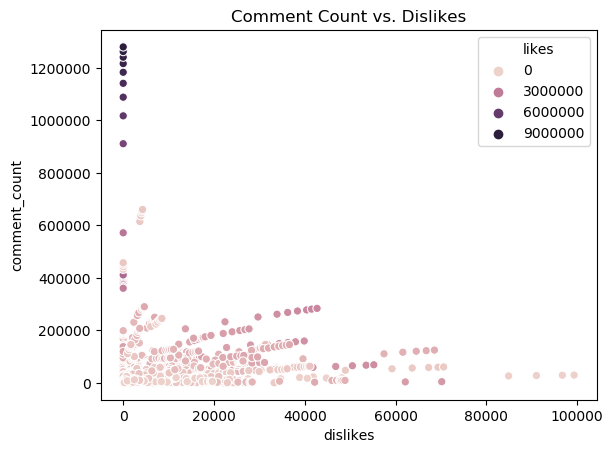

In [26]:
sns.scatterplot(data = us_gaming, x = us_gaming.dislikes, y = us_gaming.comment_count, hue = us_gaming.likes)
plt.title("Comment Count vs. Dislikes")
plt.show()

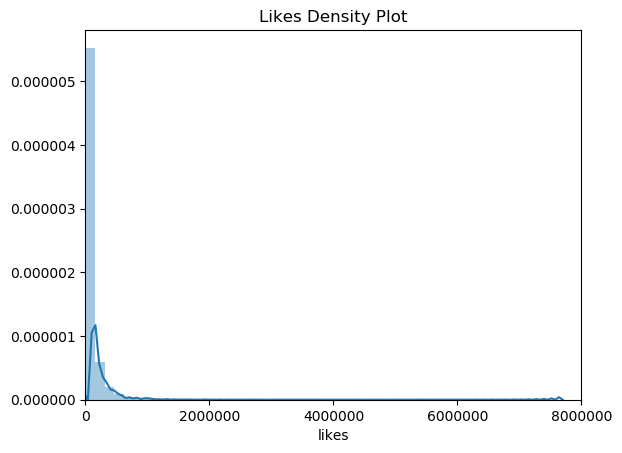

In [27]:
fig, ax = plt.subplots()

sns.distplot(us_gaming.likes, ax = ax)
plt.title("Likes Density Plot")
ax.set_xlim(0, 8000000)
ax.set_xticks([0, 2000000, 4000000, 6000000, 8000000])
plt.show()

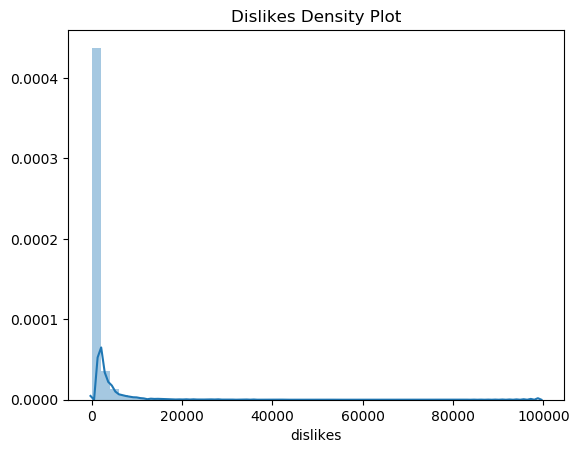

In [28]:
sns.distplot(us_gaming.dislikes)
plt.title("Dislikes Density Plot")
plt.show()

faze is a popular, legacy gaming brand at this point. Below the faze gaming organization 100t is charted as well, 100t is new gaming brand, although already find themselves very successful on YouTube. Looking at the comparison, faze, particularly prior to 2022, is the much stronger brand on YouTube, Perhaps when working out deals or collaborations with gaming brand with our creators, it would be more lucrative to attach our creators to faze's brand rather than 100t. 

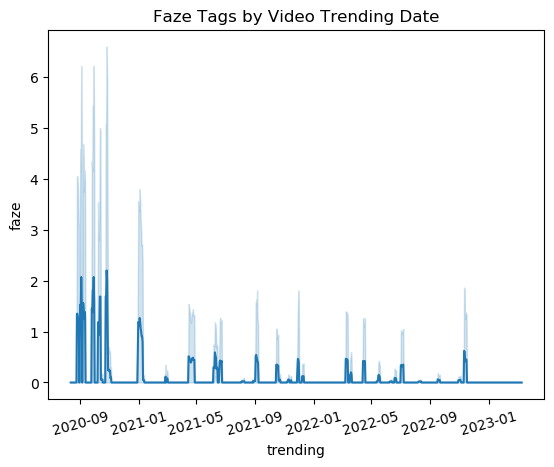

In [29]:
sns.lineplot(x = us_gaming['trending'], y = tag_df['faze'])
plt.xticks(rotation = 15)
plt.title("Faze Tags by Video Trending Date")
plt.show()

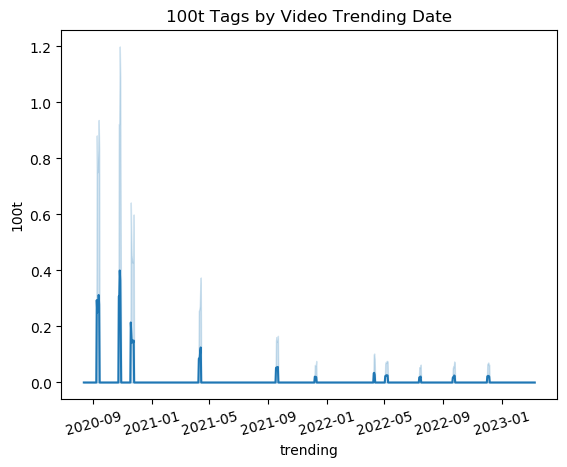

In [30]:
sns.lineplot(x = us_gaming['trending'], y = tag_df['100t'])
plt.xticks(rotation = 15)
plt.title("100t Tags by Video Trending Date")
plt.show()

Below the recently developed game Valorant is compared to Mario, one of the most popular games in existence. Mario games are more likely to trend on any given day as the time series is much more dense, but the peaks of Valorant are slightly higher. Both of these games could viably be a valuable addition to a creator's video title. 

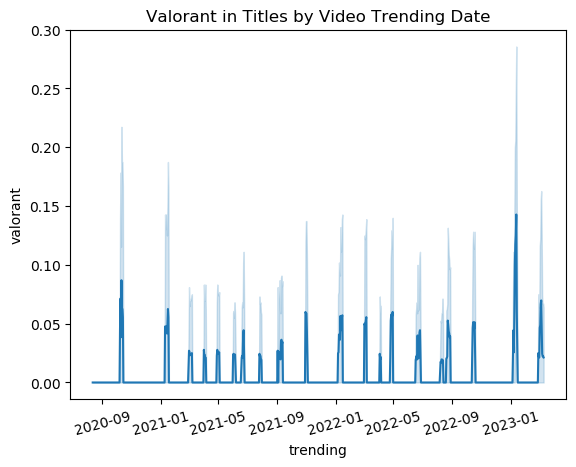

In [31]:
sns.lineplot(x = us_gaming['trending'], y = title_df['valorant'])
plt.xticks(rotation = 15)
plt.title("Valorant in Titles by Video Trending Date")
plt.show()

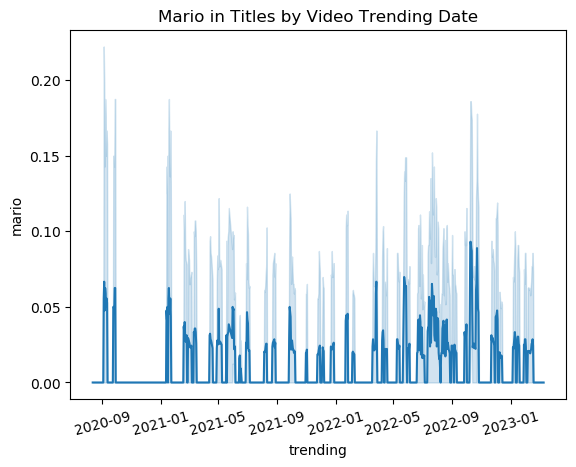

In [32]:
sns.lineplot(x = us_gaming['trending'], y = title_df['mario'])
plt.xticks(rotation = 15)
plt.title("Mario in Titles by Video Trending Date")
plt.show()